# Assignment 2: object classification

In [1]:
# Imports
import os # Module to access Operating System
import keras # Module for deep learning
!pip -q install keras-cv > /dev/null
import keras_cv # Keras module for object detection
import numpy as np # Module for matrix operations and linear algebra
import tensorflow as tf # Module for deep learning
import matplotlib.pyplot as plt # Module for plotting
from keras.applications.resnet50 import ResNet50 # Pretrained ResNet50 model

## Data analysis

In the first step, we will download the data and split the total dataset in a train, validation, and test set. We will also visualize some samples from the dataset. 

In [2]:
# Download data
if not os.path.exists('data/fish_data_classification'):
    !wget -q --no-check-certificate -O dataset.zip "https://kuleuven-my.sharepoint.com/:u:/g/personal/matthias_deryck_kuleuven_be/Ed2e5ehats5Ery2K15Gzos0B6AlAOKnBoA8FMTRm3Xmkrw?e=2G6qWx&download=1"
    !unzip -q dataset.zip -d data
    !rm dataset.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
unzip:  cannot find either dataset.zip or dataset.zip.zip.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Define class list
class_list = ['ANF', 'BIB', 'GUU', 'PLE', 'SOL', 'WIT']

In [4]:
# Get training set (70%)
train_ds = keras.utils.image_dataset_from_directory("./data/fish_data_classification/", validation_split=0.3, subset="training", seed=1337, image_size=(150, 150), batch_size=9)

# Get validation set (30%)
val_ds = keras.utils.image_dataset_from_directory("./data/fish_data_classification/", validation_split=0.3, subset="validation", seed=1337, image_size=(150, 150), batch_size=9)

# Split validation set further in 15% validation and 15% testset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((val_batches) // 2)
val_ds = val_ds.skip((val_batches) // 2)

Found 120 files belonging to 6 classes.
Using 84 files for training.
Found 120 files belonging to 6 classes.
Using 36 files for validation.


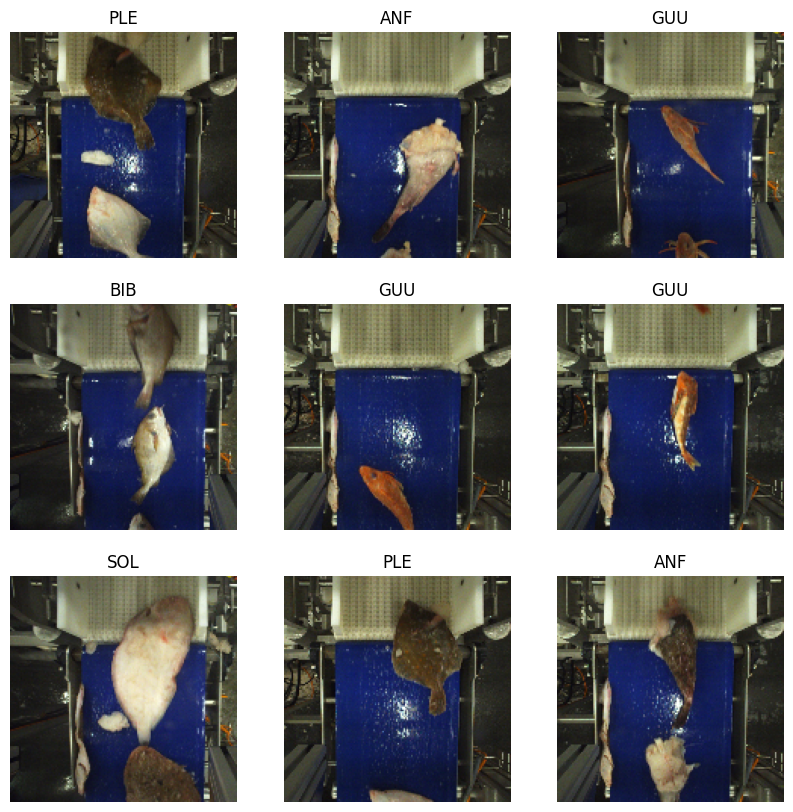

In [5]:
# Plot one batch in grid
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_list[int(labels[i])])
        plt.axis("off")

## Data preprocessing

As we have limited data, augmentation can help improving the model performance. In this case, we perform a random horizontal flip of the image, and a random rotation of the image with a probability of 10%. We visualize some augmented images and apply the data augmentation to the train images. 

In [6]:
# Define data augmentation layers
data_augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]

# Define data augmentation function
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

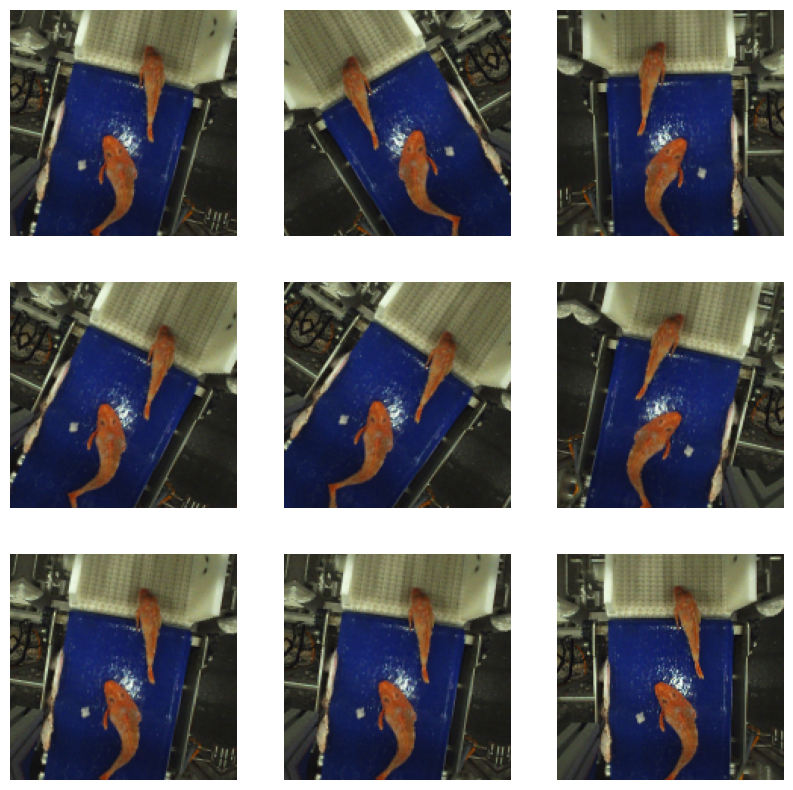

In [7]:
# Plot one batch in grid
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [8]:
# Apply data_augmentation to the training images.
train_ds = train_ds.map(lambda img, label: (data_augmentation(img), label), num_parallel_calls=tf.data.AUTOTUNE)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

## Model training

In the next step, we will train our model. The model that we use is a pretrained ResNet50 model that was trained on ImageNet. We want to finetune the model and thus also modify the parameters of the feature extraction layers. We make a new model with the feature extraction layers and a new fully connected output layer. 

In [9]:
# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Set trainable for finetuning
base_model.trainable = True

# Get the output layer of the base model
x = base_model.output

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# A Dense classifier with six units (six classes)
outputs = keras.layers.Dense(6, activation='softmax')(x)

# Define final model
model = keras.Model(base_model.input, outputs)

# Summarize final model
#model.summary(show_trainable=True)

After defining the model, we can compile it with the proper optimizer, loss function, and evaluation metrics. After that we can train it for e specified number of epochs. 

In [10]:
# Set number of epochs to train
epochs = 30

# Set optimizer, loss function, and accuracy metrics
model.compile(
    optimizer=keras.optimizers.SGD(), # Stochastic gradient descent optimizer
    loss=[keras.losses.SparseCategoricalCrossentropy()], # Crossentropy loss for multi-class classification
    metrics=[keras.metrics.SparseCategoricalAccuracy()]) # Crossentropy accuracy for multi-class classification

# Define COCO metrics callback
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    val_ds, bounding_box_format="center_xywh"
)

# Train model
model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=epochs, 
    callbacks=[coco_metrics_callback]
)

Epoch 1/50
10/10 [==============================] - 13s 808ms/step - loss: 1.8999 - sparse_categorical_accuracy: 0.2738 - val_loss: 3.8347 - val_sparse_categorical_accuracy: 0.2778
Epoch 2/50
10/10 [==============================] - 7s 734ms/step - loss: 1.0444 - sparse_categorical_accuracy: 0.6310 - val_loss: 0.7280 - val_sparse_categorical_accuracy: 0.6667
Epoch 3/50
10/10 [==============================] - 7s 727ms/step - loss: 0.7053 - sparse_categorical_accuracy: 0.7619 - val_loss: 3.3261 - val_sparse_categorical_accuracy: 0.3333
Epoch 4/50
10/10 [==============================] - 7s 731ms/step - loss: 0.3852 - sparse_categorical_accuracy: 0.9048 - val_loss: 1.3919 - val_sparse_categorical_accuracy: 0.7222
Epoch 5/50
10/10 [==============================] - 7s 742ms/step - loss: 0.2455 - sparse_categorical_accuracy: 0.9286 - val_loss: 1.9635 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/50
10/10 [==============================] - 7s 725ms/step - loss: 0.1975 - sparse_categoric

## Model validation

During training, the model was evaluated on the training and the validation set. It is important to also evaluate the model on a set of images that it has never seen before. So we evaluate it again on the test set. Lastly, we loop over several images in the dataset and predict the class as if we would do in production. 

In [11]:
# Evaluate model on test set
result = model.evaluate(test_ds)

# Print result
print(f'\nThe model has an accuracy of {result[1]*100}% on the test set')

2/2 [==============================] - 0s 200ms/step - loss: 0.0047 - sparse_categorical_accuracy: 1.0000

The model has an accuracy of 100.0% on the test set



The model predicts ANF and the ground truth class is ANF


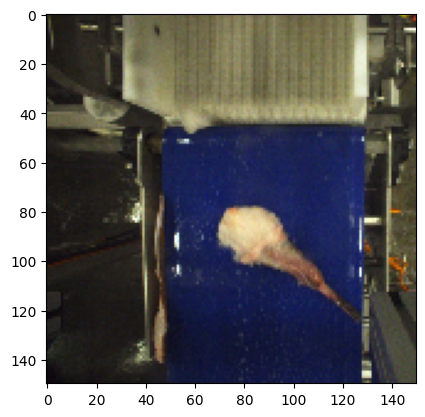


The model predicts BIB and the ground truth class is BIB


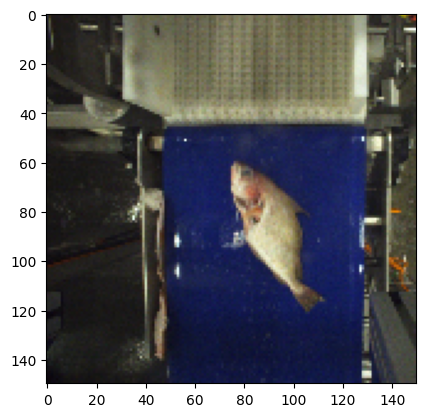


The model predicts GUU and the ground truth class is GUU


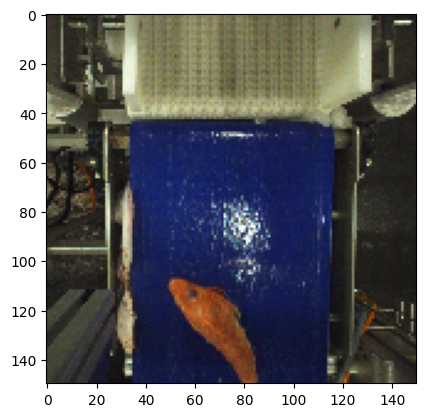


The model predicts PLE and the ground truth class is PLE


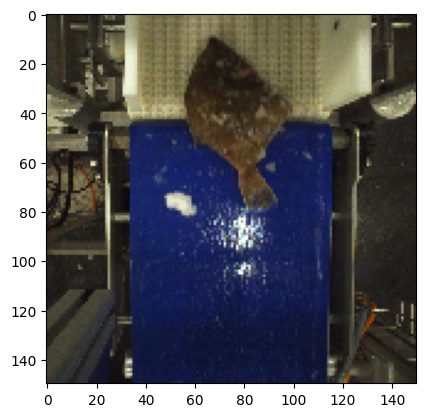


The model predicts SOL and the ground truth class is SOL


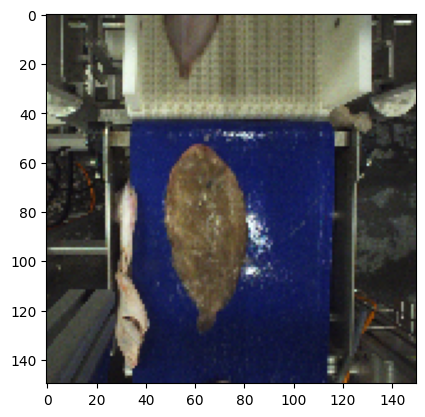


The model predicts WIT and the ground truth class is WIT


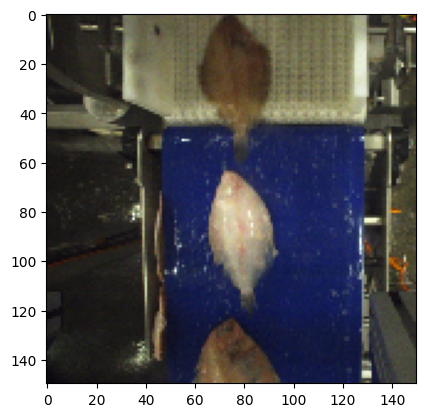

In [12]:
# Loop over all folders and predict the class for the first image
for specie in class_list:

    # Define image path of the first image in the folder
    image_path = "./data/fish_data_classification/" + specie + "/" + os.listdir("./data/fish_data_classification/" + specie)[0]
                                                    
    # Load image
    img = keras.utils.load_img(image_path, target_size=(150, 150))

    # Convert image to array
    input_arr = keras.utils.img_to_array(img)
    input_arr = np.array([input_arr])  

    # Make predictions (outputs probabilities for each function)
    predictions = model.predict(input_arr, verbose=0)

    # Get the class with the highest probability
    predicted_class = class_list[predictions.argmax()]

    # Print result
    print(f"\nThe model predicts {predicted_class} and the ground truth class is {specie}")

    # Show image
    plt.imshow(img)
    plt.show()
